In [1]:
# Import dependencies.
from __future__ import division
import pandas as pd
from os import getcwd, listdir, path
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import findspark
findspark.init()
import pyspark
import time

color = sns.color_palette()
InteractiveShell.ast_node_interactivity = "last_expr" # "last_expr" or "all"

In [2]:
# Input all the data and combine them into one dataframe.
ratings = pd.read_csv(getcwd()+"/ml-latest-small/ratings.csv")
movies = pd.read_csv(getcwd()+"/ml-latest-small/movies.csv")
links = pd.read_csv(getcwd()+"/ml-latest-small/links.csv")
result = ratings.merge(movies, on = "movieId")
result = result.merge(links, on = "movieId")
reviews_df = result.sort_values(by = "userId").reset_index(drop = True)

<font size="7", face="arial"><i><strong>Exploratory Data Analysis</strong></i></font>

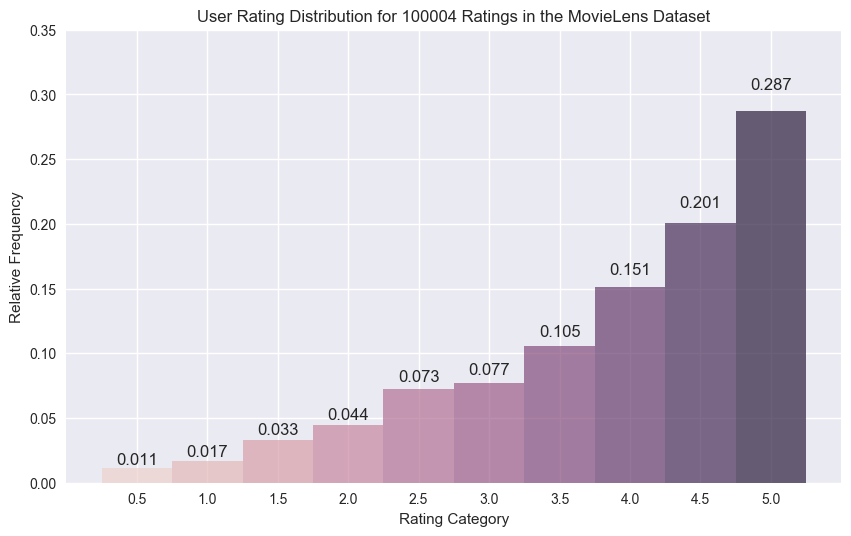

In [68]:
# Plot the user rating distribution.

N_star_categories = 10
star_labels = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
star_category_dist_fig = plt.figure(figsize = (10, 6), dpi = 100)
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = reviews_df.rating.value_counts(ascending = True)
star_category_relative_frequencies = (np.array(star_category_absolute_frequencies)/
                                      float(sum(star_category_absolute_frequencies)))
rects = (plt.bar(bar_plot_indices, star_category_relative_frequencies, width = 1, 
                 color = sns.cubehelix_palette(10), alpha = .7))

for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(), 
                       '%.3f'%(star_category_relative_frequencies[idx]), ha = 'center', va = 'bottom')

plt.xticks(bar_plot_indices, np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]))
plt.xlabel('Rating Category')
plt.ylabel('Relative Frequency')
plt.ylim([0, 0.35])
plt.title('User Rating Distribution for {} Ratings in the MovieLens Dataset'.format(len(reviews_df)))

plt.show()
# star_category_dist_fig.savefig("user_rating_distribution.png")

<p><font size="4", face="arial">As the rating gets higher, the relative frequency gets higher as well.</font></p>

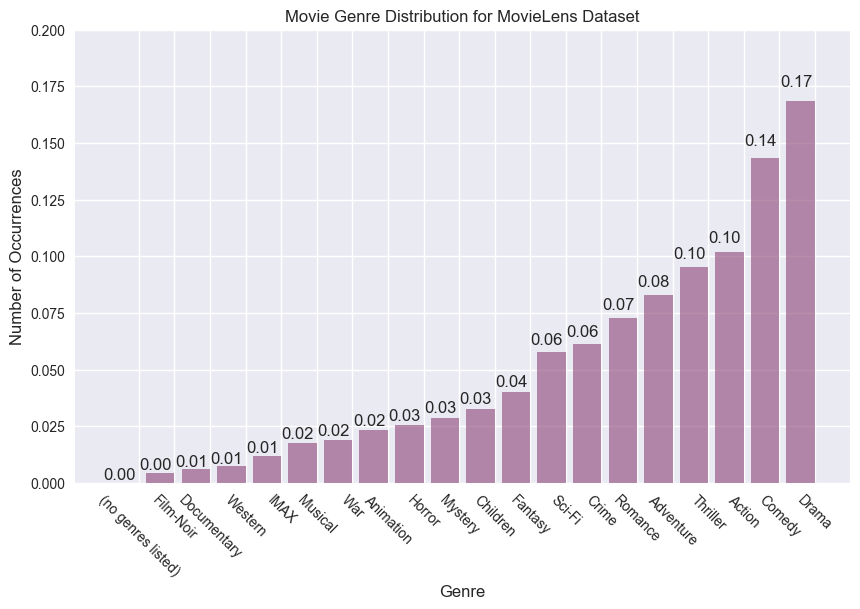

In [67]:
# Plot the genre distribution.

genre_list = [genre.split("|") for genre in reviews_df.genres]
genre_list = [str(element) for sublist in genre_list for element in sublist]

genre_df = pd.DataFrame.from_dict(dict(Counter(genre_list)), orient = "index")
genre_df["genre"] = list(genre_df.index)
genre_df.index = range(len(genre_df))
genre_df.columns = ["count", "genre"]
genre_df = genre_df.sort_values(by = "count", ascending = False).reset_index()

barplot_indices = np.arange(len(genre_df))
relative_genre_freq = [num/sum(genre_df["count"]) for num in list(genre_df["count"])]
genre_dist = plt.figure(figsize = (10, 6), dpi = 100)
rects = (plt.bar(barplot_indices[::-1], relative_genre_freq, 
                     alpha = 0.7, color = sns.cubehelix_palette(8)[4]))
for idx, rect in enumerate(rects):
    plt.gca().text(rect.get_x()+rect.get_width()/3., 1.03*rect.get_height(), 
                   "%.2f"%(relative_genre_freq[idx]), ha = 'center', va = 'bottom')
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel("Genre", fontsize = 12)
plt.xticks(barplot_indices+0.4, genre_df.genre[::-1], rotation = -45)
plt.ylim([0, 0.2])
plt.title("Movie Genre Distribution for MovieLens Dataset")
plt.show()
# num_of_words_dist.savefig("num_of_words_dist.png")

<font size="7", face="arial"><i><strong>Model</strong></i></font>

<p><font size="4", face="arial">In this section we adopt <u><strong>collaborative filtering</strong></u> as our movie recommendation model. </font></p>

<p><font size="4", face="arial">Mathematically, we can fill users and movies in a sparse matrix, where each row represents a user and each column represents a movie. A user has different taste for every movie, and this taste can be expressed as a vector where each entry is a number between 0 and 1. 1 means this user absolutely loves this movie and 0 means this user has no interest in this movie whatsoever.</font></p>

<p><font size="4", face="arial">The final outcome of this section is that, when a new user added to the dataset, the recommender will introduce a movie to this user based on similar users' taste.</font></p>

In [2]:
# sc.stop()
sc = pyspark.SparkContext()

# Import the whole dataset.
full_data = sc.textFile(path.join(getcwd(), "ml-latest-small", "ratings.csv"))

In [3]:
small_data_header = full_data.take(1)[0]

# Parse the data and read in one line of form (user, movie, rating) each time. 
small_ratings_data = (full_data.filter(lambda line: line != small_data_header)
                      .map(lambda line: line.split(","))
                      .map(lambda tokens: (tokens[0], tokens[1], tokens[2])).cache())

In [16]:
# Split the data into training, validation and testing parts.
training_RDD, validation_RDD, test_RDD = small_ratings_data.randomSplit([6, 2, 2], seed = 0L)

validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [30]:
from pyspark.mllib.recommendation import ALS
import math

seed = 5L
iterations = 15
regularization_parameter = 0.25
ranks = [4, 8, 12, 16, 20]
errors = [0, 0, 0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1
for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                      lambda_=regularization_parameter, nonnegative=True)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print 'For rank %s the RMSE is %s' % (rank, error)
    if error < min_error:
        min_error = error
        best_rank = rank

print 'The best model was trained with rank %s' % best_rank

For rank 4 the RMSE is 0.937945855142
For rank 8 the RMSE is 0.938092530051
For rank 12 the RMSE is 0.937734888173
For rank 16 the RMSE is 0.937846049702
For rank 20 the RMSE is 0.937759555792
The best model was trained with rank 12


In [18]:
model = ALS.train(training_RDD, best_rank, seed = seed, iterations = iterations, lambda_ = regularization_parameter)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print "For testing data the RMSE is %s" % (error)

For testing data the RMSE is 0.930022779832


In [8]:
training_RDD, test_RDD = small_ratings_data.randomSplit([8, 2], seed = 0L)

# Use parameters obtained above to obtain the model for recommendation.
complete_model = ALS.train(training_RDD, best_rank, seed = seed, 
                           iterations = iterations, lambda_ = regularization_parameter)

In [19]:
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

predictions = complete_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print "For testing data the RMSE is %s" % (error)

For testing data the RMSE is 0.904896322302


In [20]:
# sc.stop()
complete_movies_raw_data = sc.textFile(path.join(getcwd(), "ml-latest-small", "movies.csv"))
complete_movies_raw_data_header = complete_movies_raw_data.take(1)[0]

# Parse 
complete_movies_data = (complete_movies_raw_data.filter(lambda line: line != complete_movies_raw_data_header)
                        .map(lambda line: line.split(","))
                        .map(lambda tokens: (int(tokens[0]),tokens[1],tokens[2])).cache())

complete_movies_titles = complete_movies_data.map(lambda x: (int(x[0]), x[1]))
    
print "There are {} movies in the complete dataset".format(complete_movies_titles.count())

There are 9125 movies in the complete dataset


In [21]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return(ID_and_ratings_tuple[0], (nratings, float(sum(float(x) for x in ID_and_ratings_tuple[1]))/nratings))

movie_ID_with_ratings_RDD = small_ratings_data.map(lambda x: (x[1], x[2])).groupByKey().mapValues(list)
movie_ID_with_avg_ratings_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)
movie_rating_counts_RDD = movie_ID_with_avg_ratings_RDD.map(lambda x: (int(x[0]), x[1][0]))

<p><font size="4", face="arial">Suppose a new user is added to the dataset, and begin to perform the recommendation.</font></p>

In [22]:
new_user_ID = 0

new_user_ratings = [
     (0, 130, 4), 
     (0, 7584, 3),
     (0, 4248, 2),
     (0, 2169, 1),
     (0, 2042, 5), 
     (0, 335, 1), 
     (0, 1791, 1), 
     (0, 296, 3), 
     (0, 1350, 5) ,
     (0, 50, 5)
]

new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print "New user ratings: %s" % new_user_ratings_RDD.take(10)

New user ratings: [(0, 130, 4), (0, 7584, 3), (0, 4248, 2), (0, 2169, 1), (0, 2042, 5), (0, 335, 1), (0, 1791, 1), (0, 296, 3), (0, 1350, 5), (0, 50, 5)]


In [23]:
# Add this new user to the dataset.
complete_data_with_new_ratings_RDD = small_ratings_data.union(new_user_ratings_RDD)

In [24]:
start_time = time.time()

# Everytime a new user is added to the dataset, the model needs to be trained again.
new_ratings_model = ALS.train(complete_data_with_new_ratings_RDD, best_rank, seed = seed, 
                              iterations = iterations, lambda_ = regularization_parameter)

final_time = time.time()-start_time

print "New model trained in %s seconds" % round(final_time, 3)

New model trained in 1.718 seconds


In [25]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings)

new_user_unrated_movies_RDD = (complete_movies_data.filter(lambda x: x[0] not in new_user_ratings_ids)
                               .map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_movies_RDD, with new_ratings_model.predictAll() 
# to predict new ratings for the movies that new user has not seen.
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_movies_RDD)

In [26]:
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = (new_user_recommendations_rating_RDD
                                                       .join(complete_movies_titles).join(movie_rating_counts_RDD))

In [27]:
new_user_recommendations_rating_title_and_count_RDD = (new_user_recommendations_rating_title_and_count_RDD
                                                       .map(lambda r: (r[1][0][1], r[1][0][0], r[1][1])))

In [28]:
top_movies = (new_user_recommendations_rating_title_and_count_RDD
              .filter(lambda r: r[2] >= 25).takeOrdered(25, key = lambda x: -x[1]))

print ('TOP recommended movies (with more than 25 reviews):\n%s' % '\n'.join(map(str, top_movies)))

TOP recommended movies (with more than 25 reviews):
(u'The Imitation Game (2014)', 4.041263638455911, 32)
(u'Modern Times (1936)', 4.039358940440648, 32)
(u'Cinema Paradiso (Nuovo cinema Paradiso) (1989)', 4.009974889449146, 46)
(u'"Shawshank Redemption', 3.96476916290156, 311)
(u'"African Queen', 3.9610647070230316, 50)
(u'"Grand Budapest Hotel', 3.9519564881756244, 35)
(u'Ran (1985)', 3.9466396510918162, 26)
(u'"Godfather: Part II', 3.9361106871027696, 135)
(u'"Godfather', 3.9337965836872595, 200)
(u'Roman Holiday (1953)', 3.932600698014829, 26)
(u'Harry Potter and the Deathly Hallows: Part 2 (2011)', 3.9312275848014293, 34)
(u'It Happened One Night (1934)', 3.927240523974524, 25)
(u'To Kill a Mockingbird (1962)', 3.9235263161820417, 80)
(u'There Will Be Blood (2007)', 3.917975319468981, 26)
(u'Cool Hand Luke (1967)', 3.908373665342574, 46)
(u'In Bruges (2008)', 3.8907052913470057, 38)
(u'City of God (Cidade de Deus) (2002)', 3.8905398430065166, 69)
(u'Harry Potter and the Half-Blood